In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from brian2 import start_scope, prefs, run
from brian2 import NeuronGroup, PoissonGroup, Synapses, SpikeMonitor, StateMonitor, TimedArray
from brian2 import ms, mV, Hz

# Import libraries from outside folder
import sys
sys.path.append('../lib/')

import brian2wrapper

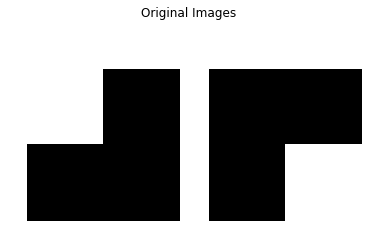

In [2]:
# Load raw images
# img1 = (mpimg.imread('img/cat4.png')[:,:,0] > 0.5).astype(int)
# img2 = (mpimg.imread('img/mouse4.png')[:,:,0] > 0.5).astype(int)
# img1 = mpimg.imread('../img/cat4.png')
# img2 = mpimg.imread('../img/mouse4.png')
img1 = np.zeros((50, 50))
img2 = np.zeros((50, 50))
img1[:25, :25] = 1
img2[25:, 25:] = 1

# Plot raw images
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(img1, cmap='gray')
axis[1].imshow(img2, cmap='gray')
axis[0].set_axis_off()
axis[1].set_axis_off()
plt.suptitle('Original Images')
plt.show()

# Marking using Symmetric Hebbian STDP plasticity

Plan:
1. Have sparsely connected Brunel network
  * Inhibitory neurons are 4x less than excitatory
  * Inhibitory neurons have 4x stronger weights than excitatory
2. Exc-Exc connections exhibit Symmetric Hebbian plasticity
<table><tr><td>
  $\dot{W}(t) = C \bigl(z^A(t) S^B(t) + z^B(t) S^A(t) \bigr)$
</td></tr></table>
3. Poisson input is sent to excitatory neurons


Questions:
* How to make sure network is still balanced after STDP?
  


In [3]:
%%time
'''
TODO:
[] Noise to both EXC, INH like in h2014
[] Extend tau to 100s
[] Try Hebbian STDP
[] STD
[] Copy input from n2014
  * NOISE_EXC = 2.0 * GAU(0.3, 0.1)
  * NOISE_INH = 0.5 * GAU(0.3, 0.1)
'''


#######################################
# Simulation
#######################################

start_scope()
prefs.codegen.target = "numpy"

RUN_TIME_1_SIM = 2000*ms
RUN_TIME_TOT = 5 * RUN_TIME_1_SIM
OUTPUT_SAMPLING_TIMESCALE = 1*ms
OUTPUT_SAMPLING_TIMESCALE_W = 5*ms


#######################################
# Neurons
#######################################

N_EXC = img1.shape[0] * img1.shape[1]
N_INH = int(N_EXC / 4)
print('Number of [EXC, INH] neurons is', N_EXC, N_INH)

# Fixed threshold neurons
LIF_V_TAU = 10*ms
LIF_V_0 = 0.0*mV
LIF_T_0 = 50.0*mV

# LIF neurons will be sparsely connected laterally
W_CONN_P_LATERAL = 0.01
REL_W_START = 0.5
DV_SPIKE_EXC_EXC = LIF_T_0 / (1.0 * N_EXC * W_CONN_P_LATERAL)
DV_SPIKE_EXC_INH = LIF_T_0 / (1.0 * N_EXC * W_CONN_P_LATERAL)
DV_SPIKE_INH_EXC = -4 * DV_SPIKE_EXC_EXC
DV_SPIKE_INH_INH = -1 * DV_SPIKE_EXC_EXC

print("typical number of presynaptic exc neurons", N_EXC * W_CONN_P_LATERAL)
print("typical number of presynaptic inh neurons", N_INH * W_CONN_P_LATERAL)
print("typical potential change per exc lateral spike", DV_SPIKE_EXC_EXC)
print("typical potential change per inh lateral spike", DV_SPIKE_INH_EXC)


#######################################
# NOISE
#######################################
NOISE_FREQ = 400*Hz
NOISE_DV_EXC = LIF_T_0 / 8
NOISE_DV_INH = LIF_T_0 / 12

#######################################
# Input
#######################################

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_FREQ_MAX = 400*Hz
INPUT_DV_PER_SPIKE = 0.5 * LIF_T_0 / LIF_V_TAU / INPUT_FREQ_MAX
print("Typical threshold is", LIF_T_0, ", voltage increase per input spike is", INPUT_DV_PER_SPIKE)

# Generate input timed arrays
rates1 = INPUT_FREQ_MAX * np.ndarray.flatten(img1)
rates2 = np.zeros(N_EXC)
rates3 = INPUT_FREQ_MAX * np.ndarray.flatten(img2)
rates_all = np.vstack((rates2, rates1, rates2, rates3, rates2)) * Hz

# NOTE: The poisson rate is changed with time step dt, resulting in new input
rateTimedArray = TimedArray(rates_all, dt = RUN_TIME_1_SIM)


#######################################
# STDP
#######################################
PLASTICITY_MODEL = {
    'TYPE'      : 'STDP_HP',
    'DV_SPIKE'  : DV_SPIKE_EXC_EXC,
    'REL_W_MIN' : 0.0,
    'REL_W_MAX' : 10.0,
    'REL_W_0'   : 0.1,
    'DW_FORW'   : 0.01,     # Maximal change of weight due to causal spike sequence
    'DW_BACK'   : 0.01,     # Maximal change of weight due to anti-causal spike sequence
    'TAU_PRE'   : 40*ms,    # STDP presynaptic spike trace timescale
    'TAU_POST'  : 20*ms,    # STDP postsynaptic spike trace timescale    
    'TAU_HP'    : 100000*ms # Timescale for synaptic homeostatic plasticity
}


#######################################
# Brian2 classes
#######################################

# Create neuronal populations
#G_INP = PoissonGroup(N_EXC, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G_EXC = brian2wrapper.NeuronGroupLIF(N_EXC, LIF_V_0, LIF_T_0, LIF_V_TAU)
G_INH = brian2wrapper.NeuronGroupLIF(N_INH, LIF_V_0, LIF_T_0, LIF_V_TAU)
G_INP = PoissonGroup(N_EXC, rates="rateTimedArray(t, i)")
G_NOISE_EXC = PoissonGroup(N_EXC, NOISE_FREQ)
G_NOISE_INH = PoissonGroup(N_INH, NOISE_FREQ)

# Create synapses
S_INP = Synapses(G_INP, G_EXC, on_pre='v_post += INPUT_DV_PER_SPIKE', method='exact')
S_NOISE_EXC = Synapses(G_NOISE_EXC, G_EXC, on_pre='v_post += NOISE_DV_EXC', method='exact')
S_NOISE_INH = Synapses(G_NOISE_INH, G_INH, on_pre='v_post += NOISE_DV_INH', method='exact')
S_EXC_EXC = brian2wrapper.SynapsesPlastic(G_EXC, G_EXC, PLASTICITY_MODEL)
S_EXC_INH = Synapses(G_EXC, G_INH, on_pre='v_post += DV_SPIKE_EXC_INH', method='exact')
S_INH_EXC = Synapses(G_INH, G_EXC, on_pre='v_post += DV_SPIKE_INH_EXC', method='exact')
S_INH_INH = Synapses(G_INH, G_INH, on_pre='v_post += DV_SPIKE_INH_INH', method='exact')

# Connect synapses:
# * Input and LIF one-to-one
# * LIF neurons to each other sparsely
S_INP.connect(j='i')    
S_NOISE_EXC.connect(j='i') 
S_NOISE_INH.connect(j='i') 
S_EXC_EXC.connect(p=W_CONN_P_LATERAL)   
S_EXC_INH.connect(p=W_CONN_P_LATERAL)
S_INH_EXC.connect(p=W_CONN_P_LATERAL)
S_INH_INH.connect(p=W_CONN_P_LATERAL)

# Initialize STDP variable
S_EXC_EXC.w = 'REL_W_START'

spikemon_inp = SpikeMonitor(G_INP)
spikemon_exc = SpikeMonitor(G_EXC)

statemon_s_exc_exc = StateMonitor(S_EXC_EXC, 'w', record=True, dt=OUTPUT_SAMPLING_TIMESCALE_W)


#######################################
# Run sim
#######################################

run(RUN_TIME_TOT)

Number of [EXC, INH] neurons is 2500 625
typical number of presynaptic exc neurons 25.0
typical number of presynaptic inh neurons 6.25
typical potential change per exc lateral spike 2. mV
typical potential change per inh lateral spike -8. mV
Typical threshold is 50. mV , voltage increase per input spike is 6.25 mV
CPU times: user 14min 30s, sys: 1.24 s, total: 14min 31s
Wall time: 14min 31s


Started writing video rez/test3_lif_inp.avi of 10000 frames using time step 0.001
Started writing video rez/test3_lif_exc.avi of 10000 frames using time step 0.001


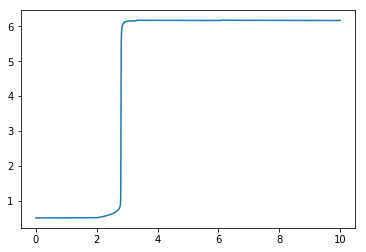

Min weight after training is 0.46193533002867393
Max weight after training is 10.0
Average weight after training is 6.1673950215041975


In [4]:
#######################################
# Write videos
#######################################

import traces_lib

TAU_SMOOTH = 0.05
N_DISCR_STEPS = int(RUN_TIME_TOT / OUTPUT_SAMPLING_TIMESCALE)

# Input spikes
traces_lib.spikes2rateVideo(
    'rez/test3_lif_inp.avi',
    img1.shape,
    np.array(spikemon_inp.i),
    np.array(spikemon_inp.t),
    0,
    float(RUN_TIME_TOT),
    N_DISCR_STEPS,
    TAU_SMOOTH,
    maxRate=int(INPUT_FREQ_MAX))

# Spikes
traces_lib.spikes2rateVideo(
    'rez/test3_lif_exc.avi',
    img1.shape,
    np.array(spikemon_exc.i),
    np.array(spikemon_exc.t),
    0,
    float(RUN_TIME_TOT),
    N_DISCR_STEPS,
    TAU_SMOOTH,
    maxRate=150)


avgWeight = np.average(np.array(statemon_s_exc_exc.w), axis=0)
timeDW = np.linspace(0, RUN_TIME_TOT, len(avgWeight))

plt.figure()
plt.plot(timeDW, avgWeight)
plt.show()


#Report resulting weights
print("Min weight after training is", np.min(np.array(S_EXC_EXC.w)))
print("Max weight after training is", np.max(np.array(S_EXC_EXC.w)))
print("Average weight after training is", np.average(np.array(S_EXC_EXC.w)))

In [5]:
print(np.array(statemon_s_exc_exc.w).shape)

(62757, 2000)


### Mean-field analysis [wrong]

<table><tr><td>
  $\begin{eqnarray}
    \dot{V}^{E}_i &=& \frac{V^{E,0} - V^{E}_i}{\tau_{E}} - T^{E}S^{E}_i + \Delta V^{E} \sum_j S^{E}_j W^{EE}_{ji} - \Delta V^{I} \sum_j S^{I}_j W^{IE}_{ji} + \dot{V}^{inp}_i\\
    \dot{V}^{I}_i &=& \frac{V^{I,0} - V^{I}_i}{\tau_{I}} - T^{I}S^{I}_i + \Delta V_{E} \sum_j S^{E}_j W^{EI}_{ji}  - \Delta V_{I} \sum_j S^{I}_j W^{II}_{ji}
  \end{eqnarray}$
</td></tr></table>
Approximate all weights of a particular connection to be the same. Define
<table><tr><td>
  $\begin{eqnarray}
    N^E \Delta V_{E} W^{EE}_{ji} &\approx& N^E \Delta V_{E} W^{EE} PCONN^{EE} = \Delta V^{EE} \\
    N^E \Delta V_{E} W^{EI}_{ji} &\approx& N^E \Delta V_{E} W^{EI} PCONN^{EI} = \Delta V^{EI} \\
    N^I \Delta V_{I} W^{IE}_{ji} &\approx& N^I \Delta V_{I} W^{IE} PCONN^{IE} = \Delta V^{IE} \\
    N^I \Delta V_{I} W^{II}_{ji} &\approx& N^I \Delta V_{I} W^{II} PCONN^{II} = \Delta V^{II}
  \end{eqnarray}$
</td></tr></table>
Perform time-averaging over time window of a few spikes. Assume that weight does not change significantly within that time-period, but it is enough to precisely estimate the spike rate. Also, approximate all spike rates by their averages
<table><tr><td>
  $\begin{eqnarray}
    R^{E} &\approx& \frac{1}{N^{E}} \sum_i R^{E}_i \approx \frac{1}{N^{E}} \sum_i \langle S^{E}_i \rangle_t \\
    R^{I} &\approx& \frac{1}{N^{I}} \sum_i R^{I}_i \approx \frac{1}{N^{I}} \sum_i \langle S^{I}_i \rangle_t
  \end{eqnarray}$
</td></tr></table>
Find time and ensemble-averages of other quantities as well
<table><tr><td>
  $\begin{eqnarray}
    \langle \dot{V}^{E}_i \rangle_t &\approx& 0 \\
    \langle \dot{V}^{I}_i \rangle_t &\approx& 0 \\
    \biggl\langle \sum_i (V^{E,0} - V^{E}_i) \biggr\rangle_t &\approx& \frac{T^E}{2} \\
    \biggl\langle \sum_i (V^{I,0} - V^{I}_i) \biggr\rangle_t &\approx& \frac{T^I}{2} \\
  \end{eqnarray}$
</td></tr></table>
Taking time and ensemble-averages of all ODE, we get
<table><tr><td>
  $\begin{eqnarray}
    0 &=& -\frac{T^E}{2\tau_{E}} - T^{E}R^{E} + \Delta V^{EE} R^{E} - \Delta V^{IE} R^{I} + \dot{V}^{inp}\\
    0 &=& -\frac{T^I}{2\tau_{I}} - T^{I}R^{I} + \Delta V^{EI} R^{E} - \Delta V_{II} R^{I}
  \end{eqnarray}$
</td></tr></table>
Rewriting
<table><tr><td>
  $\begin{eqnarray}
    R^{E}(T^{E} - \Delta V^{EE}) + R^{I} \Delta V^{IE} &=& \dot{V}^{inp} - \frac{T^E}{2\tau_{E}}\\
    R^{I}(T^{I} + \Delta V^{II}) - R^{E} \Delta V^{EI} &=& -\frac{T^I}{2\tau_{I}}
  \end{eqnarray}$
</td></tr></table>
